In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


In [3]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Class names
classes = train_dataset.classes


100%|██████████| 170M/170M [00:01<00:00, 96.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
#Defining the class for Linear regression model
class ManualClassification_ANN(nn.Module):
    def __init__(self, input_features, h_layer1, h_layer2, h_layer3, h_layer4, n_classes):
        super(ManualClassification_ANN, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(input_features, h_layer1, requires_grad=True))
        self.b1 = torch.nn.Parameter(torch.zeros(h_layer1, requires_grad=True))
        self.w2 = torch.nn.Parameter(torch.randn(h_layer1, h_layer2, requires_grad=True))
        self.b2 = torch.nn.Parameter(torch.zeros(h_layer2, requires_grad=True))
        self.w3 = torch.nn.Parameter(torch.randn(h_layer2, h_layer3, requires_grad=True))
        self.b3 = torch.nn.Parameter(torch.zeros(h_layer3, requires_grad=True))
        self.w4 = torch.nn.Parameter(torch.randn(h_layer3, h_layer4, requires_grad=True))
        self.b4 = torch.nn.Parameter(torch.zeros(h_layer4, requires_grad=True))
        self.w5 = torch.nn.Parameter(torch.randn(h_layer4, n_classes, requires_grad=True))
        self.b5 = torch.nn.Parameter(torch.zeros(n_classes, requires_grad=True))


    def forward(self, X):
        y1 = torch.relu(torch.mm(X, self.w1) + self.b1)
        y2 = torch.relu(torch.mm(y1, self.w2) + self.b2)
        y3 = torch.relu(torch.mm(y2, self.w3) + self.b3)
        y4 = torch.relu(torch.mm(y3, self.w4) + self.b4)
        y5 = torch.mm(y4, self.w5) + self.b5
        return y5

In [5]:
def train_model(model, train_loader, loss_fn, optimizer, num_epochs):
    train_accuracies = []
    train_losses = []

    # Training phase
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        correct = 0
        total = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # Flatten images

            # Forward pass
            outputs = model.forward(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Print training metrics
        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%"
        )

    return train_losses, train_accuracies



In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model_with_overall_metrics(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten the images for ANN
            images = images.view(images.size(0), -1)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_labels, all_predictions, average='macro')  # Macro average for balanced datasets
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    accuracy = accuracy_score(all_labels, all_predictions)

    # Print overall metrics
    print("Overall Model Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")

    return accuracy, precision, recall, f1


In [7]:
# Model parameters
input_size = 32 * 32 * 3
num_classes = 10  # CIFAR-10 has 10 classes

# Initialize the model
model = ManualClassification_ANN(input_size, 3500, 2000, 1024, 512, num_classes)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adaptive learning rate


In [8]:
# Train the model
num_epochs = 20
train_losses, train_accuracies = train_model(model, train_loader, loss_fn, optimizer, num_epochs)

Epoch [1/20], Train Loss: 7321396.1208, Train Accuracy: 24.61%
Epoch [2/20], Train Loss: 2022302.9325, Train Accuracy: 27.16%
Epoch [3/20], Train Loss: 1053836.4573, Train Accuracy: 27.65%
Epoch [4/20], Train Loss: 671636.2190, Train Accuracy: 29.01%
Epoch [5/20], Train Loss: 467637.1991, Train Accuracy: 30.02%
Epoch [6/20], Train Loss: 342774.0316, Train Accuracy: 30.90%
Epoch [7/20], Train Loss: 254386.0963, Train Accuracy: 32.13%
Epoch [8/20], Train Loss: 197193.1154, Train Accuracy: 32.23%
Epoch [9/20], Train Loss: 152150.1923, Train Accuracy: 33.21%
Epoch [10/20], Train Loss: 118929.2435, Train Accuracy: 33.41%
Epoch [11/20], Train Loss: 93714.8335, Train Accuracy: 33.94%
Epoch [12/20], Train Loss: 74001.8639, Train Accuracy: 34.23%
Epoch [13/20], Train Loss: 59112.7002, Train Accuracy: 34.50%
Epoch [14/20], Train Loss: 47394.7789, Train Accuracy: 34.84%
Epoch [15/20], Train Loss: 37482.9757, Train Accuracy: 35.08%
Epoch [16/20], Train Loss: 29834.1551, Train Accuracy: 35.11%
Epoc

In [9]:
# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model_with_overall_metrics(model, test_loader)


Overall Model Metrics:
Accuracy: 31.66%
Precision: 37.27%
Recall: 31.66%
F1-Score: 27.45%


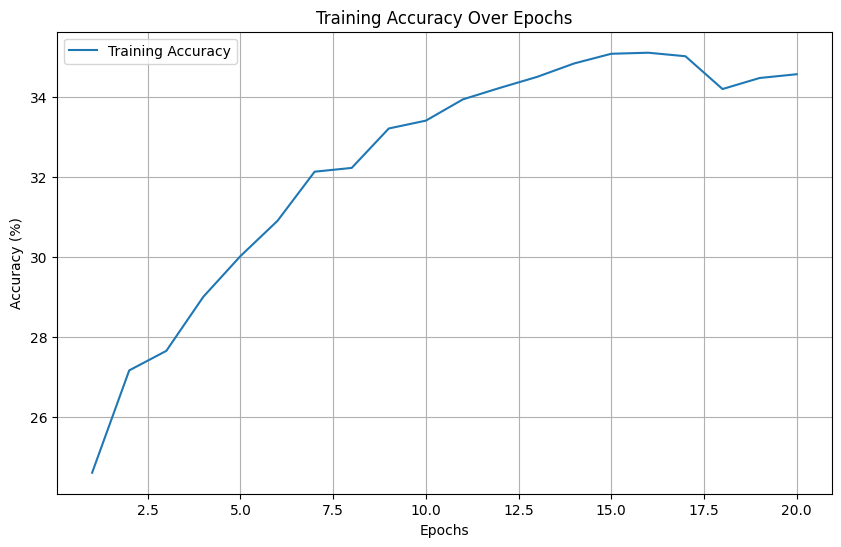

In [10]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()
